In [1]:
import numpy as np
import sys
import pprint
import glob
import os
import matplotlib.pyplot as plt

sys.path.append('./')

In [2]:
# A helper function to chronologically sort the globbed files.
def sort_files(files_l, data_pol):
    files_dict = dict()
    for type_index, data_type in enumerate(list(set(data_pol))):
        files = []
        for file_index, file in enumerate(files_l):
            field_polarisation = file.split('.')[0][-len(data_type):]
            
            if field_polarisation == data_type:
                files.append(file)
        sim_times = [X.split('_')[-2] for X in files]
        sim_times = [float(X.split('-')[0]) for X in sim_times]
        files = [x for _, x in sorted(zip(sim_times, files), key=lambda pair: pair[0])]
        files_dict[data_type] = files
    return files_dict

# A helper function to only load in npz files with the correct polerization.
def get_files(files, data_pol):
    files_l = []
    for file in files:
        for dat in data_pol:
            if not os.path.isdir(file) and file.split('.')[0][-len(dat):] == dat:
                sim_end = file.split('-')[-1]
                sim_end = sim_end.split('_')[0]
                if sim_end not in ['52054','51680', '32168']:
                    files_l.append(file)
    files_dict = sort_files(files_l, data_pol)
    pprint.pprint(files_dict, width=100)
    return files_dict

# A helper function to find the an element in a list with its value being the
# closest to a user-specified one.
def find_closest_element(input_value, input_list):
    closest_element = None
    min_difference = float('inf')

    for element in input_list:
        difference = abs(input_value - element)
        if difference < min_difference:
            min_difference = difference
            closest_element = element

    return closest_element

# From files sorted, load in the electric fields, grid and times.
def load_fields(data_pol, files_dict, path):
    fields = dict()
    time_tot = dict()
    print('\nLoading in data ...')
    for data_type in list(set(data_pol)):
        fields[data_type] = []
        time_tot = []
        for file in files_dict[data_type]:
            data = np.load(file)
            grid     = data['GridGrid'][0]
            for key in data.keys():
                if key == 'time' or key == 'GridGrid':
                    continue
                field = data[key]
                print(key)
            time     = data['time']
            fields[data_type].extend(field)
            time_tot.extend(time)
        fields[data_type] = np.array(fields[data_type])
        time_tot = np.array(time_tot)
    return fields, time_tot, grid

# A master function to load in files and return the fields, time of sim and grid.
def load_in_data_master(data_pol, path):
    files = glob.glob(path + '/*')
    files_dict = get_files(files, data_pol)
    if any(not value for value in files_dict.values()):
        sys.exit("Error: No files loaded in for atleast one polerization. Both path and polerizations have to match:\n\nPath:" + path + '\n\nKey(s): ' + str(data_pol))
    fields, time_tot, grid = load_fields(data_pol, files_dict, path)
    return fields, time_tot, grid
    


# Helper function to create fancy-plot for terminal.
def create_fancy_window(text, horizontal_char="-", vertical_char="|", border_width=1, use_bold=True):
    bold_code = "\033[1m" if use_bold else ""
    reset_code = "\033[0m"

    lines = text.splitlines()
    max_length = max(len(line) for line in lines)

    # Create the top border
    top_border = '\n\n' + horizontal_char * (max_length + 2 * border_width)
    result = [top_border]

    # Create the middle part with text and borders
    for line in lines:
        padding = " " * (max_length - len(line) + 2)
        bordered_line = f"{vertical_char}{bold_code} {line}{padding}{reset_code}{vertical_char}"
        result.append(bordered_line)

    # Create the bottom border
    bottom_border = horizontal_char * (max_length + 2 * border_width)
    result.append(bottom_border)

    return "\n".join(result)

def load_in_data(data_pol, path):
    fields, time_tot, grid = load_in_data_master(data_pol, path)

    text=f"""
    Simulation parameters:
        
    Length of grid: {len(grid)}
    grid min/max: {grid[0]}, {grid[-1]}
    
    Length of time: {len(time_tot)}
    time min/max: {time_tot[0]}, {time_tot[-1]}
    """
    
    fancy_window = create_fancy_window(text, horizontal_char="-", vertical_char="|", border_width=2)
    print(fancy_window)
    return fields, time_tot, grid


In [3]:
name = 'TPD_SingleDaughterGauss_Rune_sorted' # Navn på mappen
path = "gitignored_data/" + name + "/"
types = ['DerivedNumberDensityElectron', 'ElectricFieldEx','dist_fnx_pxElectron','ElectricFieldEz', 'DerivedTemperatureElectron','DerivedTemperatureDeuterium']

data_pol = [types[1]]


field, _time, _grid = load_in_data(data_pol, path)
time = _time[:-1]
grid = _grid[:-1]
Ex = field[data_pol[0]][:-1, :]
del field

{'ElectricFieldEx': ['gitignored_data/TPD_SingleDaughterGauss_Rune_sorted/TPD_SingleDaughterGauss_Rune_0-55552_ElectricFieldEx.npz']}

Loading in data ...
ElectricFieldEx


------------------------------------------------
|                                               |
|     Simulation parameters:                    |
|                                               |
|     Length of grid: 1601                      |
|     grid min/max: -0.01, 0.01                 |
|                                               |
|     Length of time: 55553                     |
|     time min/max: 1.980536815239028e-14, 0.0  |
|                                               |
------------------------------------------------


In [4]:
n_e = '0.255e19*exp(-(x/0.008)^2)'
T_e = '100'
source_freq = '140e9'
source_t_profile = '2/pi*atan(time*5e9) * (1/pi * atan(-(time - 15e-9) * 5e9) + 0.5)'
B0 = '2.4'

In [5]:
np.savez('../epoch_data/epoch_trapped_UH.npz', t = time, x = grid, E = Ex, n_e=n_e, T_e=T_e, source_freq=source_freq, source_t_profile=source_t_profile, B0=B0)

# Plots 

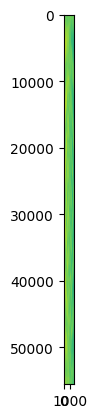

In [18]:
plt.imshow(Ex)
plt.show()

In [19]:
x = grid
t = time

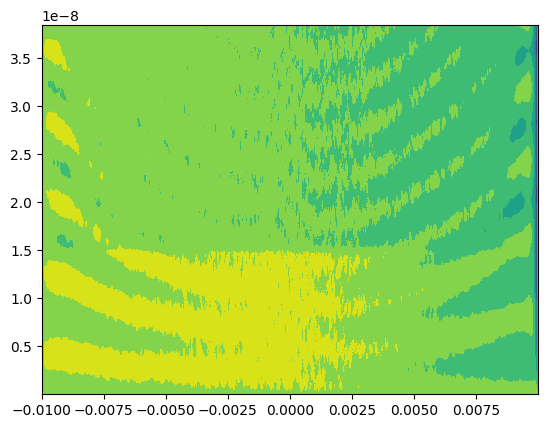

In [15]:
X, T = np.meshgrid(x, t)
plt.contourf(X, T, Ex)

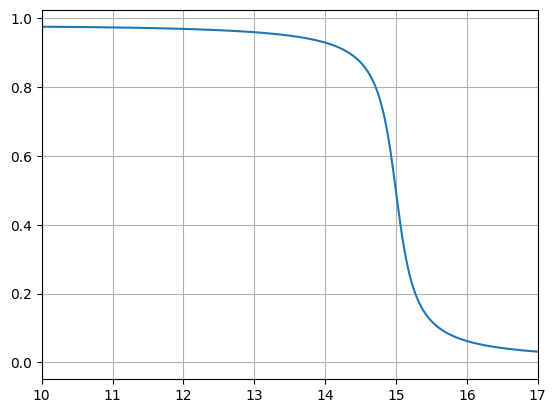

In [61]:
laser = 2/np.pi*np.atan(time*5e9) * (1/np.pi * np.atan(-(time - 15e-9) * 5e9) + 0.5)

plt.plot(time*1e9, laser)
plt.xlim(10, 17)
plt.grid()

((55552, 1600), (1600,), (55552,))

In [62]:
tmin = 14.0e-9
tmax = tmin + 0.1e-9
where_t = np.where((t >= tmin) & (t <= tmax))
# vmax = np.quantile(Ex[where_t]*1e-6, 0.9)
vmax = 0.8

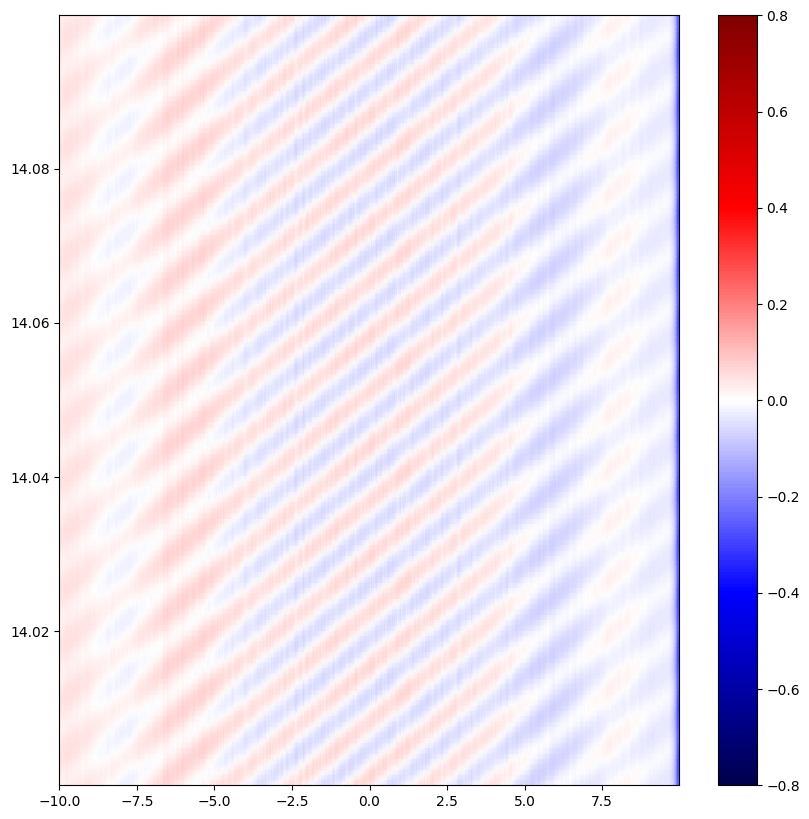

In [63]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(x*1e3, t[where_t]*1e9, Ex[where_t]*1e-6, vmin=-vmax, vmax=vmax, shading='gouraud', cmap='seismic')
plt.colorbar()
plt.show()

In [25]:
np.min(Ex[where_t]*1e-6), np.quantile(Ex[where_t]*1e-6, 0.1), np.quantile(Ex[where_t]*1e-6, 0.5), np.quantile(Ex[where_t]*1e-6, 0.1), np.max(Ex[where_t]*1e-6)

(np.float64(-0.26834648776350534),
 np.float64(-0.026840859772833434),
 np.float64(0.0003949216478488128),
 np.float64(-0.026840859772833434),
 np.float64(0.05211874227111283))